In [16]:
# Notlar
# Pandas -> Veri analizi için hızlı ve kullanımı kolay açık kaynak kodlu kütüphane
# numpy -> Matematiksel işlemler için
# matplotlib -> grafik arayüzü

# Gerekli paketlerin yüklenmesi

import pandas 
import quandl
import numpy

# Oluşturduğumuz API key'ı girelim
quandl.ApiConfig.api_key = ''

#örnek Hisseler -> Pfizer(PFE),Microsoft(MSFT)EOD/MSFT,VISA(V),IBM, INTEL(INTC), EURONEXT/RNO
#Strateji oluşturmak amacıyla istediğimiz hissenin belli aralıktaki verilerini getirelim
pay_senedi = "EOD/IBM"

hisse_veri = quandl.get(pay_senedi, start_date="2010-01-01", end_date="2020-01-01")

# API bağlantısından gelen ilk 5 satırı inceleyelim

hisse_veri.head()



,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
Date,,,,,,,,,,,,
2013-09-03,183.63,184.32,182.51,183.96,3487200.0,0.0,1.0,138.936083,139.458143,138.088681,139.185764,3487200.0
2013-09-04,183.58,184.19,182.31,183.13,2597900.0,0.0,1.0,138.898253,139.359784,137.937359,138.557779,2597900.0
2013-09-05,183.35,185.00,183.07,184.15,2867600.0,0.0,1.0,138.724233,139.972637,138.512382,139.329520,2867600.0
2013-09-06,184.65,184.99,182.65,183.03,2903500.0,0.0,1.0,139.707824,139.965071,138.194606,138.482118,2903500.0
2013-09-09,183.68,185.49,183.31,184.98,3017200.0,0.0,1.0,138.973913,140.343375,138.693968,139.957505,3017200.0


In [17]:
# Veriyi tanıyalım

# hisse_veri.info()

# Özet istatistiksel verileri

# hisse_veri.describe()

# Aylık ortalama zaman serisi oluşturmak amacıyla pandas resample() metotdunu kullanalım / Frekans değeri "M"
# Doc -> https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html

hisse_veri.resample('M').mean().head()

,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
Date,,,,,,,,,,,,
2013-09-30,188.933000,190.106495,187.765255,188.767000,3.574405e+06,0.0000,1.0,142.948380,143.836256,142.064854,142.822783,3.574405e+06
2013-10-31,180.443913,181.740865,179.405361,180.710000,5.694222e+06,0.0000,1.0,136.525461,137.506747,135.739684,136.726785,5.694222e+06
2013-11-30,181.090505,182.421385,180.135800,181.333500,5.049245e+06,0.0475,1.0,137.632927,138.644882,136.907425,137.818135,5.049245e+06
2013-12-31,178.780714,180.192429,177.875762,179.114762,4.666338e+06,0.0000,1.0,135.984207,137.057985,135.295882,136.238290,4.666338e+06
2014-01-31,184.145476,185.453314,182.780086,184.066667,5.880443e+06,0.0000,1.0,140.064753,141.059521,139.026210,140.004809,5.880443e+06


In [18]:
# Finansal Getiriyi hesaplıyalım // Belli bir zaman sürecinde getiri veya kaybın yüzdesel ifadesi 

# günlük kapanış değişkenimizi belirleyelim
gunluk_kapanis = hisse_veri[['Adj_Close']]

# gunluk değişimi hesaplayalım //Numpy percent_changea
gunluk_degisim = gunluk_kapanis.pct_change()

# N/A değerlere 0 atayalım
gunluk_degisim.fillna(0, inplace=True)

# Kapanıs fiyatlarına göre oluşturulmuş günlük değişim tablo yüzdesel olarak bakalım 
print(gunluk_degisim*100)

            Adj_Close
Date                 
2013-09-03   0.000000
2013-09-04  -0.451185
2013-09-05   0.556981
2013-09-06  -0.608200
2013-09-09   1.065399
...               ...
2017-12-21  -0.948022
2017-12-22   0.660066
2017-12-26   0.216393
2017-12-27   0.196297
2017-12-28   0.594266

[1090 rows x 1 columns]


In [19]:
# Zaman serisine göre aylık değişimlerin hesaplanası
# Ay sonu kapanışa ulaşmak için bir gün önceki veriye ihtiyacımız var

# apply metotdu fonksiyon değişkeni alarak serideki her satır için uygular
# lambda python'da anonim fonksiyon olarak isim tanımlanmadan kullanılabilir
averi = hisse_veri.resample("M").apply(lambda x:x[-1])

aylik_degisim = averi.pct_change()

# N/A değerlere 0 atayalım
aylik_degisim.fillna(0, inplace=True)

# print(aylik_degisim*100)

In [20]:
# Momentum Temelli Algoritmik işlem strajisinin oluşturulması

# 50 günlük Hareketli Ortalamanın hesaplanması
# doc -> rolling() -- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.window.rolling.Rolling.mean.html
# zaman serisinde 1 günlük her harekette ortalama tekrar hesaplanıyor
h_ort = gunluk_kapanis.rolling(window=50).mean()

# Serideki son 10 ortalamayı görelim

print(h_ort[-10:])


             Adj_Close
Date                  
2017-12-14  131.436677
2017-12-15  131.562115
2017-12-18  131.706077
2017-12-19  131.832670
2017-12-20  131.935338
2017-12-21  132.027964
2017-12-22  132.148077
2017-12-26  132.272712
2017-12-27  132.407191
2017-12-28  132.562440


<AxesSubplot:xlabel='Date'>

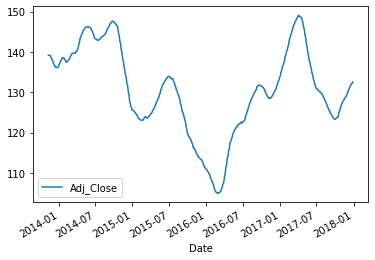

In [21]:
# Hareketli ortalamayı görselleştirelim

import matplotlib.pyplot as plt

h_ort.plot()

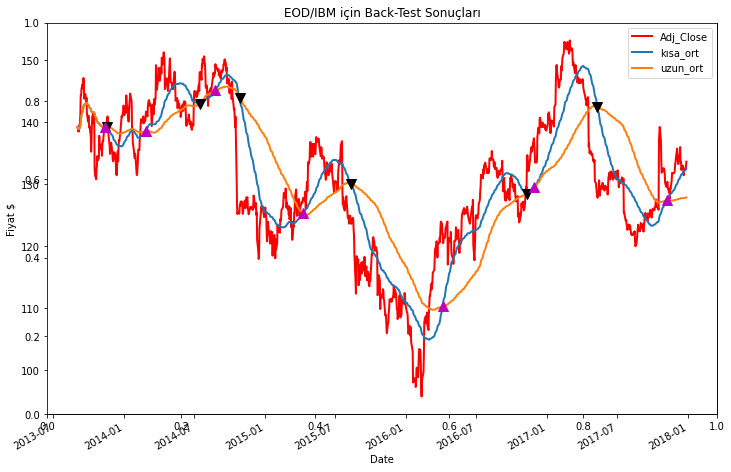

In [22]:
# Hareketli ortalamaları kullanarak, momentum temelli stratejimizi oluşturalım
# Amacımız trend oluşumuna göre alım ve satım yapmak, bu amaçla ilk farklı zaman serisi oluşturmamız gerekiyor,
# Alım sinyalimiz kısa vadeli olan hareketli ortalamanın uzun vadeli ortalamanın üzerine çıkmasıyla oluşması, Satım sinyalimiz ise tam tersi kısa vadeli hareketli çizgimizin uzun vadeli hareketli çizgisinin altına inmesiyle oluşuyor

# Kısa ve Uzun zaman periyotlarını belirleyelim / 50 ve 120 gün
kısa_periyot = 50
uzun_periyot = 120

# Sinyal degişkenimizle Dataframe'mizi oluşturalım 
# doc -> https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html
sinyal_dg= pandas.DataFrame(index=hisse_veri.index)

# sinyal kolunu ekleyelim
sinyal_dg['sinyal'] = 0.0

# Kısa vadeli hareketli ortalamamız için zaman serisini oluşturalım
sinyal_dg['kısa_ort'] = gunluk_kapanis.rolling(window=kısa_periyot,min_periods=1,center=False).mean()

# Uzun vadeli hareketli ortalamamız için zaman serisi oluşturalım
sinyal_dg['uzun_ort'] = gunluk_kapanis.rolling(window=uzun_periyot,min_periods=1,center=False).mean()

# Alım ve satım sinyalinin tetiklenmesi için koşulumuzu yazılım
# numpy.where -> https://numpy.org/doc/stable/reference/generated/numpy.where.html
sinyal_dg['sinyal'][kısa_periyot:] = numpy.where(sinyal_dg['kısa_ort'][kısa_periyot:] > sinyal_dg['uzun_ort'][kısa_periyot:],1.0,0.0)

# İşlem strajimize uygun olarak pozisyonumuzu belirleyerek işlem yapalım
# doc -> https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.diff.html
sinyal_dg['pozisyon'] = sinyal_dg['sinyal'].diff()
sinyal_dg[sinyal_dg['pozisyon'] == -1.0]

# İşlemin görselleştirilmesi
#grafik
fig = plt.figure()

#başlık
plt.title(pay_senedi + " için Back-Test Sonuçları")

# Fiyat etiketini oluşturalım
plt1 = fig.add_subplot(111, ylabel ='Fiyat $')

# Gunlük kapaniş grafiğimizi çizelim
gunluk_kapanis.plot(ax=plt1, color='r', lw=2.)

# Kısa ve uzun vadeli hareketli ortalamalarımızı çizelim
sinyal_dg[['kısa_ort','uzun_ort']].plot(ax=plt1, lw=2., figsize=(12,8))

# Sat Sintalini Çizelim
plt1.plot(sinyal_dg.loc[sinyal_dg.pozisyon == -1.0].index, sinyal_dg.kısa_ort[sinyal_dg.pozisyon == -1.0],'v', markersize=10, color='k')

# Al Sinyalinizi çizel
plt1.plot(sinyal_dg.loc[sinyal_dg.pozisyon == 1.0].index, sinyal_dg.kısa_ort[sinyal_dg.pozisyon == 1.0],'^', markersize=10, color='m')    

# plt.show()